In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import importlib
# import ising_analysis
# importlib.reload(ising_analysis)

In [ ]:
colors = ['salmon','dodgerblue','mediumseagreen']
colors = ['#FFA0A0','#1e90ff','#3cb371']
colors_light = ['#FFEDED','#6BDDFF','#89FFBE']

### Ising Model with Next-Nearest-Neighbor (NNN) Interaction

Via Metropolis sampling and Convolutional RBM (CRBM) with Gibbs sampling, we will try to simulate the Ising Model with NNN and NN interactions in two dimensions:
$$
H = J_1 \sum_{\langle i,j \rangle} s_i s_j + J_2 \sum_{\langle \langle i,j \rangle \rangle} s_i s_j
$$
where $J_1 > 0$, $J_2 \geq 0$, $s_i = \pm 1$, $\langle i,j \rangle$ denotes nearest-neighbor sites, and $\langle \langle i,j \rangle \rangle$ denotes NNN sites.

### References

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.76.064528

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.79.014439

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.174407

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.45.7832

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.63.2148

https://aip.scitation.org/doi/10.1063/1.1664978

### Load data

In [ ]:
throwaway = 2000

In [ ]:
L = 64
T = 2.27
J1 = -1.0
J2 = 0.0

In [ ]:
data_correlated_MC = np.loadtxt("./data_nnn/L_"+str(L)+"_T_"+str(T)+"_J1_"+str(J1)+"_J2_"+str(J2)+"_seed_1968.dat")[:,1][throwaway:]
data_correlated_CRBM = np.loadtxt("./data_nnn/L_"+str(L)+"_T_"+str(T)+"_J1_"+str(J1)+"_J2_"+str(J2)+"_kernelDims_2-2_no_symmetries.dat")[:,1][throwaway:]

### Energy in MC vs CRBM

In [ ]:
num_samples_MC = data_correlated_MC.shape[0]
num_samples_CRBM = data_correlated_CRBM.shape[0]

In [ ]:
plt.plot(np.arange(num_samples_MC),data_correlated_MC,color="tab:blue",alpha=1.0,label="MC")
plt.plot(np.arange(num_samples_CRBM),data_correlated_CRBM,color="tab:orange",alpha=1.0,label="CRBM")
plt.ylabel(r"$E$")
plt.xlabel(r"Sample Number")
plt.tick_params(direction="in")
plt.legend(frameon=False)

In [ ]:
np.mean(data_correlated_MC)/L**2,np.mean(data_correlated_CRBM)/L**2

In [ ]:
#NOTE: Do binning analysis

### Autocorrelation time

In [170]:
def autocorrelation(data):
    '''Computes normalized autocorrelation function of sample data for each time'''
    N = data.shape[0]
    _autocorrelation = np.zeros(N)
    for Δt in range(N-1): # let the time separation be all possible distances
        c0 = np.mean(data[:N - Δt]**2) - np.mean(data[:N - Δt])**2 #Variance at t0
        ct = np.mean(data[:N - Δt]*data[Δt:]) - np.mean(data[:N - Δt])*np.mean(data[Δt:]) # unnormalized autocorrelation fn.
        _autocorrelation[Δt] = ct/c0 # normalized autocorrelation function for this 'radius' (actually time separation)
    return _autocorrelation

def autocorrelation_function(time,scale,autocorrelation_time):
    '''exponential form of the autocorrelation function'''
    return scale*np.exp(-time/autocorrelation_time)

In [171]:
# Compute normalized autocorrelation function
_autocorrelation_MC = autocorrelation(data_correlated_MC)
_autocorrelation_CRBM = autocorrelation(data_correlated_CRBM)

# Eliminate nans (there's usually just a few)
_autocorrelation_MC = np.ma.masked_array(_autocorrelation_MC, ~np.isfinite(_autocorrelation_MC)).filled(0)
_autocorrelation_CRBM = np.ma.masked_array(_autocorrelation_CRBM, ~np.isfinite(_autocorrelation_CRBM)).filled(0)

# Time separations
time_separation = np.arange(_autocorrelation_MC.shape[0])

KeyboardInterrupt: 

In [545]:
# Fit autocorrelation to exponential form for all time separations
popt_MC, perr_MC = curve_fit(autocorrelation_function, time_separation, _autocorrelation_MC)
popt_CRBM, perr_CRBM = curve_fit(autocorrelation_function, time_separation, _autocorrelation_CRBM)

In [546]:
data_correlated_CRBM.shape

(48000,)

In [547]:
print("τ_auto: {}".format(popt_MC[1])) # from fitting
print("4τ_auto: {}".format(4*popt_MC[1]))
print("\n")
print("τ_auto: {}".format(popt_CRBM[1])) # from fitting
print("4τ_auto: {}".format(4*popt_CRBM[1]))

τ_auto: 760.0593755395694
4τ_auto: 3040.2375021582775


τ_auto: 693.0496318387469
4τ_auto: 2772.1985273549876


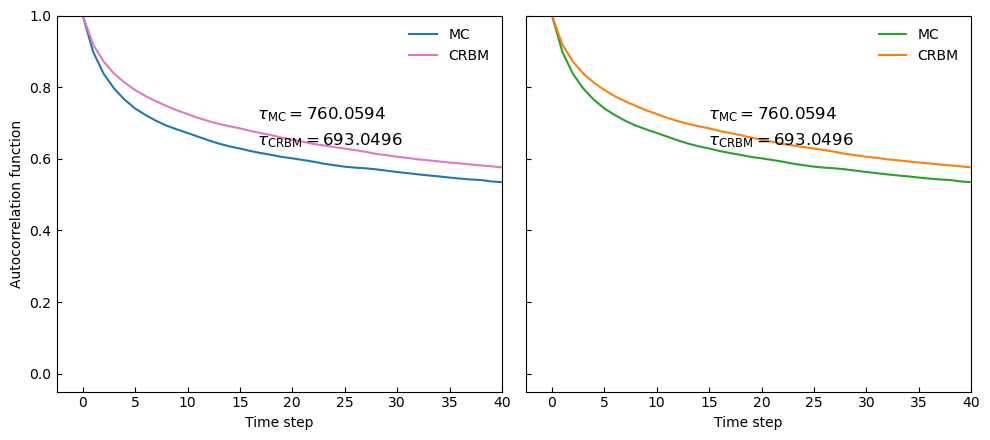

In [548]:
# Plot
fig,ax = plt.subplots(1,2,figsize=(10,4.5), dpi=100,sharey=True,tight_layout=True)
plt.subplots_adjust(wspace=0.02)
ax[0].plot(time_separation, _autocorrelation_MC,'-',color='tab:blue',label='MC') # autocorrelation function
ax[0].plot(time_separation, _autocorrelation_CRBM,'-',color='tab:pink',label='CRBM') # autocorrelation function

ax[0].set_xlim((-2.5,40))
ax[0].set_ylim(-0.05,1)
ax[0].set_yscale('linear')
ax[0].set_ylabel(r'Autocorrelation function');
ax[0].set_xlabel(r'Time step');
ax[0].tick_params(direction='in')
ax[0].legend(frameon=False)
ax[0].annotate(r"$\tau_{\rm{MC}}=%.4f$"%(popt_MC[1]),(0.20+0.06,0.58+0.15),
                xycoords='figure fraction',fontsize=12)
ax[0].annotate(r"$\tau_{\rm{CRBM}}=%.4f$"%(popt_CRBM[1]),(0.20+0.06,0.58+0.09),
                xycoords='figure fraction',fontsize=12)

ax[1].plot(time_separation, _autocorrelation_MC,'-',color='tab:green',label='MC') # autocorrelation function
ax[1].plot(time_separation, _autocorrelation_CRBM,'-',color='tab:orange',label='CRBM') # autocorrelation function

ax[1].set_xlim((-2.5,40))
ax[1].set_ylim(-0.05,1)
ax[1].set_yscale('linear')
ax[1].set_ylabel(r'');
ax[1].set_xlabel(r'Time step');
ax[1].tick_params(direction='in')
ax[1].legend(frameon=False)
ax[1].annotate(r"$\tau_{\rm{MC}}=%.4f$"%(popt_MC[1]),(0.655+0.06,0.58+0.15),
                xycoords='figure fraction',fontsize=12)
ax[1].annotate(r"$\tau_{\rm{CRBM}}=%.4f$"%(popt_CRBM[1]),(0.655+0.06,0.58+0.09),
                xycoords='figure fraction',fontsize=12)

# plt.savefig("act_comparison_T4.00_mc_rbm_combined.pdf",dpi=300)
# plt.savefig("act_comparison_T4.00_mc_rbm_combined.png",dpi=300)

plt.show()

### Autocorrelation time as a function of linear size

In [478]:
# τ_MC = []
# τ_MC_err = []

# τ_CRBM = []
# τ_CRBM_err = []

# τ_CRBM_2kernels = []
# τ_CRBM_err_2kernels = []

In [352]:
# τ_MC.append(popt_MC[1])
# τ_MC_err.append(np.diag(perr_MC)[1])

# τ_CRBM.append(popt_CRBM[1])
# τ_CRBM_err.append(np.diag(perr_CRBM)[1])

# τ_CRBM_2kernels.append(popt_CRBM[1])
# τ_CRBM_err_2kernels.append(np.diag(perr_CRBM)[1])

In [353]:
# τ_MC = np.array(τ_MC)
# τ_MC_err = np.array(τ_MC_err)

# τ_CRBM = np.array(τ_CRBM)
# τ_CRBM_err = np.array(τ_CRBM_err)

# τ_CRBM_2kernels = np.array(τ_CRBM_2kernels)
# τ_CRBM_err_2kernels = np.array(τ_CRBM_err_2kernels)

In [354]:
Ls = np.array([2**i for i in range(2,9)]).astype(np.float32)

In [355]:
Ls.shape

(7,)

In [356]:
τ_MC.shape

NameError: name 'τ_MC' is not defined

In [357]:
τ_MC

NameError: name 'τ_MC' is not defined

In [138]:
τ_MC_err.shape

NameError: name 'τ_MC_err' is not defined

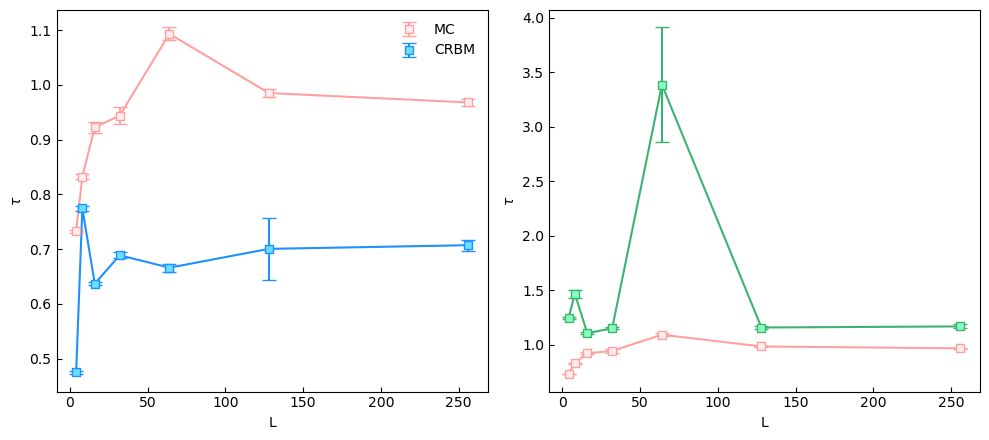

In [411]:
# Plot
fig,ax = plt.subplots(1,2,figsize=(10,4.5), dpi=100,sharey=False,tight_layout=True)
plt.subplots_adjust(wspace=0.02)

ax[0].errorbar(Ls,τ_MC, yerr=τ_MC_err, fmt='.', capsize=5,
                label='MC',color=colors[0],mfc=colors_light[0],marker='s',zorder=2)
ax[0].plot(Ls,τ_MC,color=colors[0])

ax[0].errorbar(Ls,τ_CRBM, yerr=τ_CRBM_err, fmt='.', capsize=5,
                label='CRBM',color=colors[1],mfc=colors_light[1],marker='s',zorder=2)
ax[0].plot(Ls,τ_CRBM,color=colors[1])

ax[0].set_ylabel(r'$\tau$');
ax[0].set_xlabel(r'L');
ax[0].tick_params(direction='in')
ax[0].legend(frameon=False)
# ax[0].annotate(r"$\tau_{\rm{MC}}=%.4f$"%(popt_MC[1]),(0.20+0.06,0.58+0.15),
#                 xycoords='figure fraction',fontsize=12)
# ax[0].annotate(r"$\tau_{\rm{CRBM}}=%.4f$"%(popt_CRBM[1]),(0.20+0.06,0.58+0.09),
#                 xycoords='figure fraction',fontsize=12)

# plt.savefig("act_comparison_T4.00_mc_rbm_combined.pdf",dpi=300)
# plt.savefig("act_comparison_T4.00_mc_rbm_combined.png",dpi=300)

ax[1].errorbar(Ls,τ_MC, yerr=τ_MC_err, fmt='.', capsize=5,
                label='MC',color=colors[0],mfc=colors_light[0],marker='s',zorder=2)
ax[1].plot(Ls,τ_MC,color=colors[0])

ax[1].errorbar(Ls,τ_CRBM_2kernels, yerr=τ_CRBM_err_2kernels, fmt='.', capsize=5,
                label='CRBM',color=colors[2],mfc=colors_light[2],marker='s',zorder=2)
ax[1].plot(Ls,τ_CRBM_2kernels,color=colors[2])

ax[1].set_ylabel(r'$\tau$');
ax[1].set_xlabel(r'L');
ax[1].tick_params(direction='in')
# ax[1].legend(frameon=False)
# ax[0].annotate(r"$\tau_{\rm{MC}}=%.4f$"%(popt_MC[1]),(0.20+0.06,0.58+0.15),
#                 xycoords='figure fraction',fontsize=12)
# ax[0].annotate(r"$\tau_{\rm{CRBM}}=%.4f$"%(popt_CRBM[1]),(0.20+0.06,0.58+0.09),
#                 xycoords='figure fraction',fontsize=12)

# plt.savefig("act_comparison_T4.00_mc_rbm_combined.pdf",dpi=300)
# plt.savefig("act_comparison_T4.00_mc_rbm_combined.png",dpi=300)

plt.show()

### $E/J_1$ vs $J_2/J_1$

### Specific heat

Recall that the specific heat can be computed as:
$$
C_v = \frac{1}{K_B T^2} \left [ \langle E^2 \rangle - \langle E \rangle^2 \right ]
$$

In [167]:
L = 8
T = 2.25
E = np.loadtxt("./data_nnn/L_"+str(L)+"_T_2.25_J1_1.0_J2_1.0_kernelDims_4-3_no_symmetries.dat")[:,0][throwaway:]
E2 = np.loadtxt("./data_nnn/L_"+str(L)+"_T_2.25_J1_1.0_J2_1.0_kernelDims_4-3_no_symmetries.dat")[:,2][throwaway:]

In [380]:
E2_mean = np.mean(E2)
E_mean = np.mean(E)

In [381]:
Cv = (1/T**2)*(E2_mean - E_mean**2)

In [384]:
Cv

2.9769878439521875